In [3]:
import sys
# import numpy as np
# import matplotlib.pyplot as plt
import pandas as pd
# import lightkurve as lk
# from scipy.optimize import curve_fit

# from astropy.convolution import Gaussian1DKernel
# from astropy.convolution import convolve
sys.path.insert(0, "../")

from michael import janet

In [4]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

Index 258 is a good tester. Clear rotational signal, ambiguous peak mode.

In [5]:
j = janet.boot(uni, index=259)

Making folder /Users/oliver hall/Research/unicorn/data/2227100384482274048/...
Found star in Sector(s) 17 18 24 25


No eleanor postcard has been made for your target (yet). Using TessCut instead.
No eleanor postcard has been made for your target (yet). Using TessCut instead.
No eleanor postcard has been made for your target (yet). Using TessCut instead.
No eleanor postcard has been made for your target (yet). Using TessCut instead.


### Running Simple Astropy Lomb-Scargle on Sector 17 on star 2227100384482274048 ###
### Completed Simple Astropy Lomb-Scargle for Sector 17 on star 2227100384482274048 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector 18 on star 2227100384482274048 ###
### Completed Simple Astropy Lomb-Scargle for Sector 18 on star 2227100384482274048 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector 24 on star 2227100384482274048 ###
### Completed Simple Astropy Lomb-Scargle for Sector 24 on star 2227100384482274048 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector 25 on star 2227100384482274048 ###
### Completed Simple Astropy Lomb-Scargle for Sector 25 on star 2227100384482274048 ###
### Saved results ###
### Running Wavelet Estimation on star 2227100384482274048 ###


/Users/Anaconda/anaconda3/lib/python3.8/site-packages/jazzhands/wavelets.py:488: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm



### Completed Wavelet Estimation on star 2227100384482274048 ###
### Saved results ###
### Running ACF Estimation on star 2227100384482274048 ###
### Completed ACF Estimation on star 2227100384482274048 ###
### Saved results ###

------ Decoding Overall Period Flag 17 ------
16: Valididation between WS and SLS was done using a SLS period that was not the 'best' SLS value (lowest uncertainty without flags), because there was no 2 sigma agreement with the SW period.
1: Best rotation is from the Simple Lomb Scargle (SLS) method.

No other flags raised. 



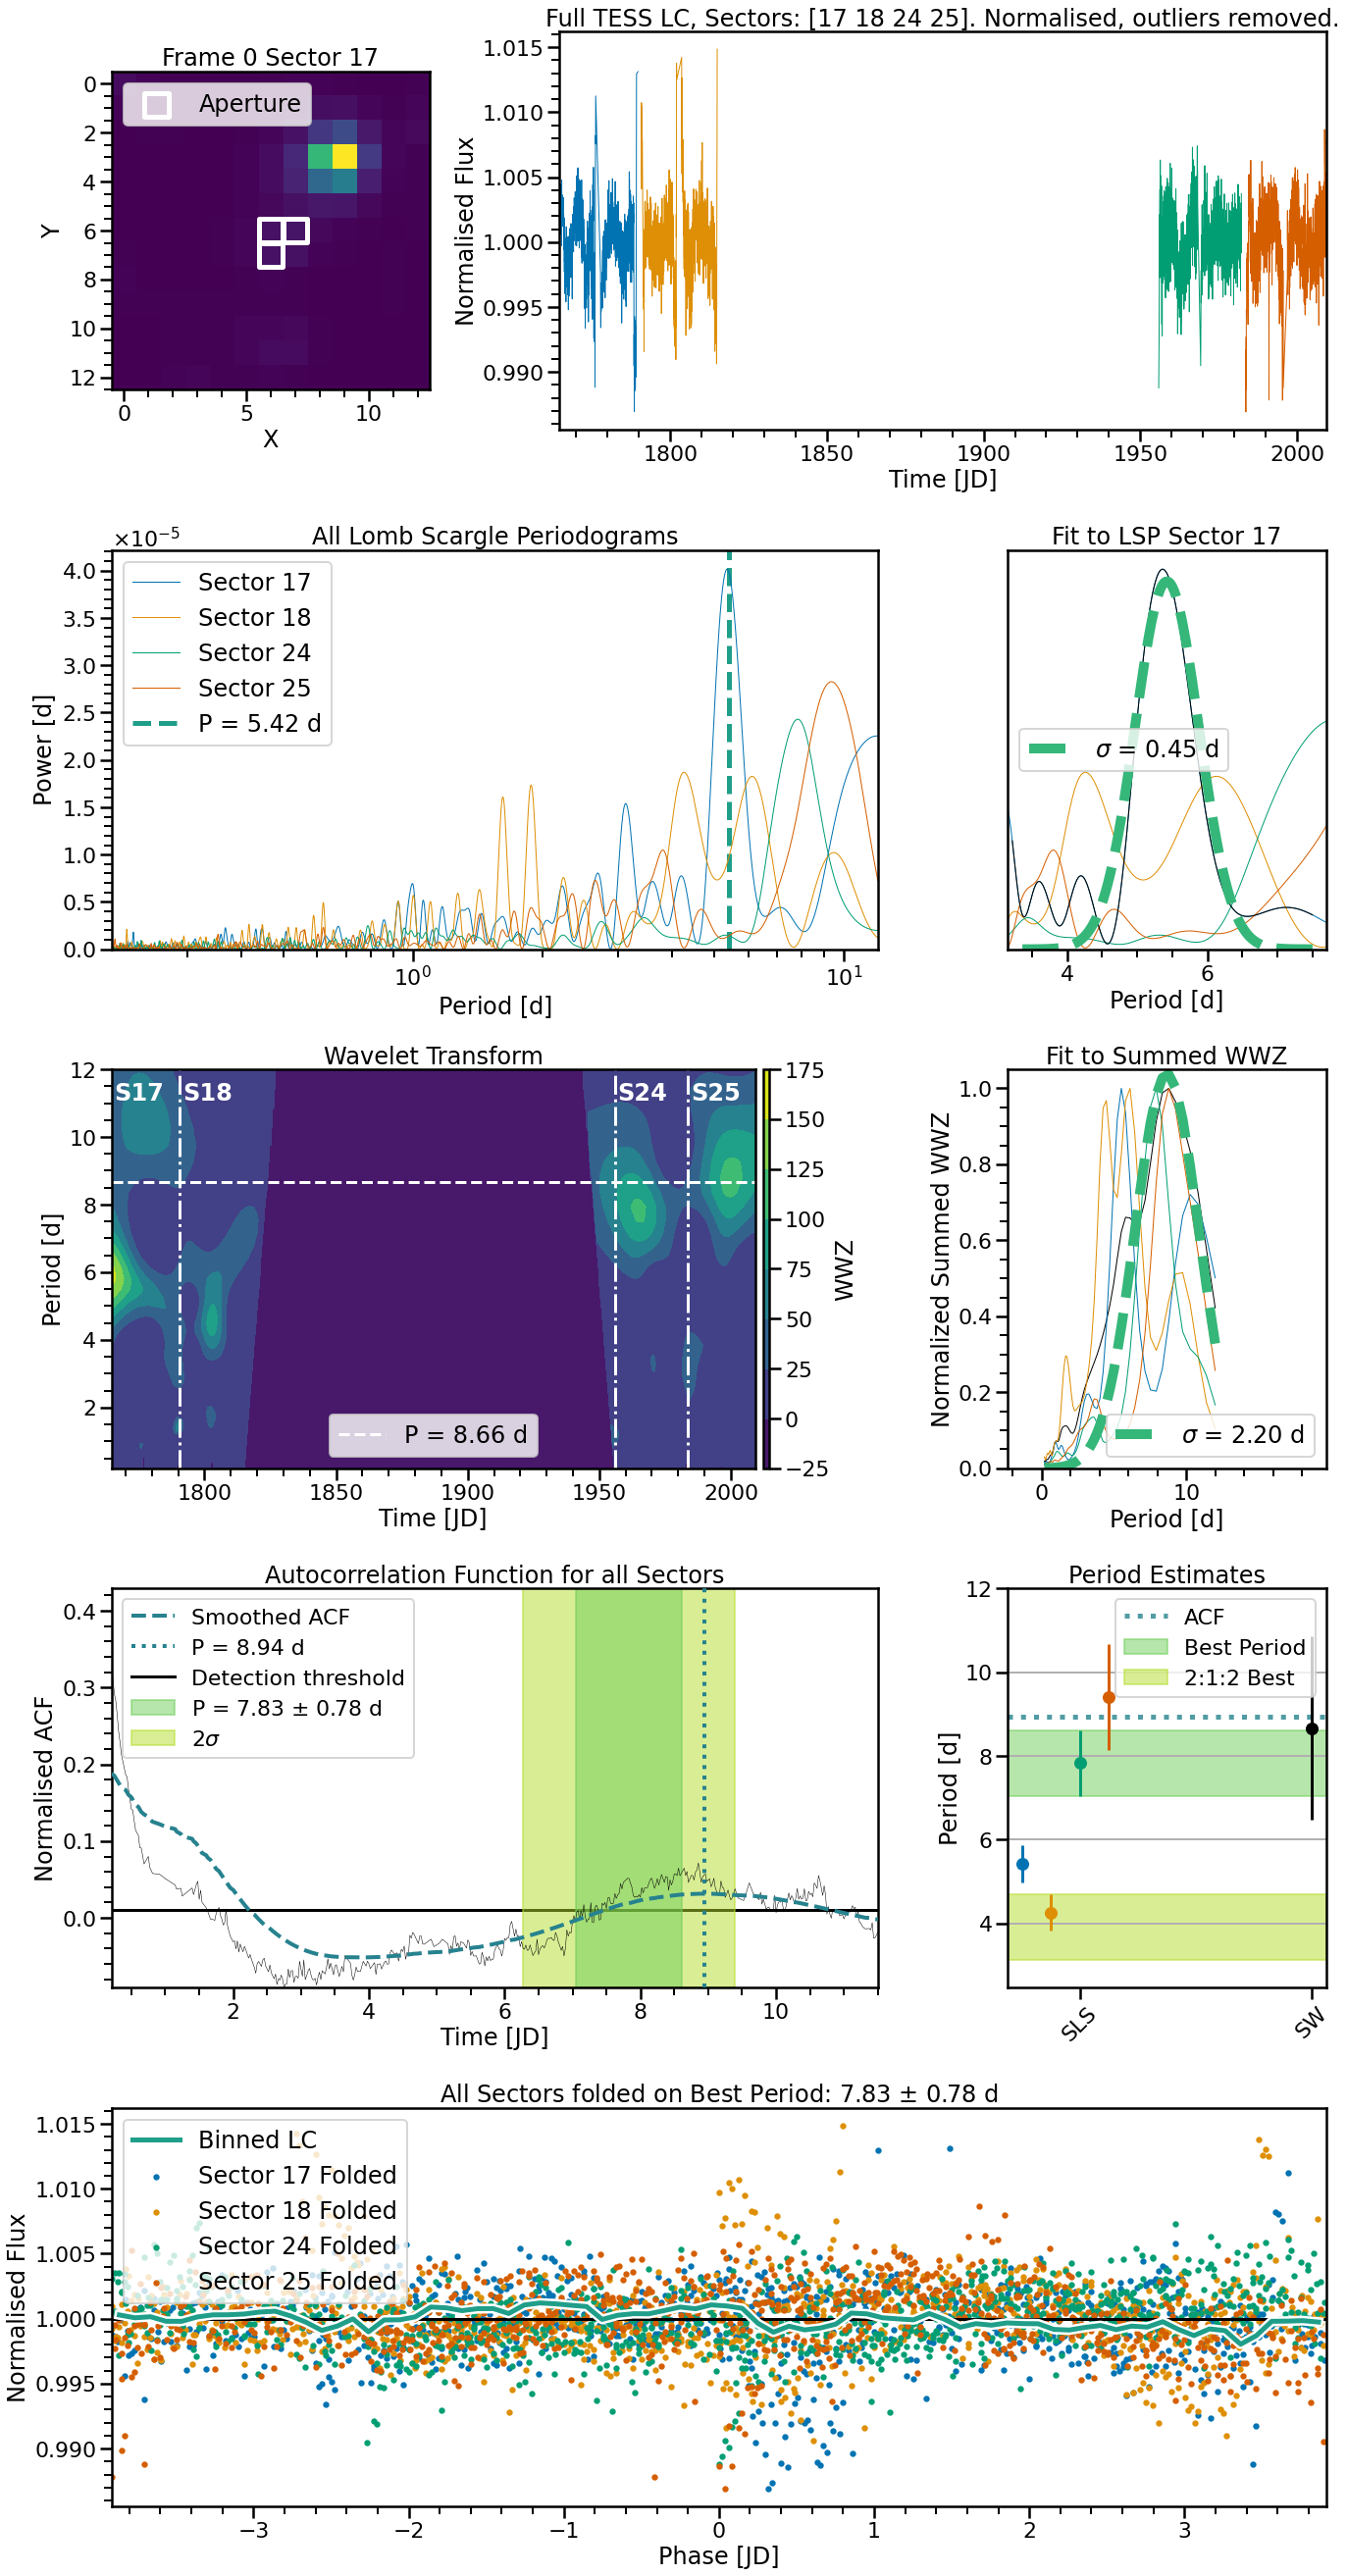

In [6]:
j.run()